# Predicting Patient Survival from After Diagnosis with NSCLC

In this project, the survival of patients will be predicted 1-year after being diagnosed with Non-small cell lung cancer (NSCLC). Survival is going to be the target/dependent variable in this study which can take one of two values (True/False or 1/0) and as such this is a classification problem.

## Things to address:
1. Describe data exploration (i.e., dealing with missing/bad entries, any interesting trends, descriptive statistics,etc.)
2. What features will be used for the model?
3. What algorithm to use for prediction?
4. How will model performance be assessed?
5. Future work?
 
 ## Part 1: Importing Necessary Modules

In [132]:
#General modules
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import numpy as np
from math import nan, isnan
#Plotting modules
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns

## Part 2: Loading the Data
The data to be loaded is in two .csv files named clinical.csv and genomics.csv. As such it can be readily loaded using the pandas function 'read_csv'.

In [43]:
#Load the data
clinical_df = pd.read_csv('clinical.csv')
genomics_df = pd.read_csv('genomics.csv')

## Part 3: Basic exploration of the clinical data  

In [44]:
clinical_df

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations
0,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8
1,2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,NaN,2,2
2,3,Dead,13.0,72,3,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1
3,4,Dead,15.0,69,9,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,NaN,4,4
4,5,Dead,10.0,76,9,0,UNK,NaN,NaN,0,IIIA,Left Hilar,Large-cell carcinoma,NaN,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,186,Dead,32.0,82,9,0,4,0.0,1.0,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2
186,187,Dead,10.0,62,4,0,3,2.0,NaN,0,IVB,Left Hilar,Large-cell carcinoma,NaN,3,5
187,188,Dead,23.0,72,3,0,3,NaN,NaN,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3
188,189,Dead,32.0,67,4,1,1a,NaN,0.0,0,IV,Right Upper Lobe,Adenocarcinoma,10.0,3,3


Hmmm, this dataset is rather small (only 190 patients) so I'll have to ensure that I preserve as much data as possible when dealing with any bad/missing entries to maximize the effectiveness and predicatability of my model(s).

I also have 16 different data features. The Outcome column is of particular interest since this will be my model target (i.e., did the patient survive or not at the time of checkup). Hence, I have initially 15 potential base features to build my model with.

Let me check the datatypes I have present

In [45]:
clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 190 non-null    int64  
 1   Outcome            190 non-null    object 
 2   Survival.Months    190 non-null    float64
 3   Age                190 non-null    int64  
 4   Grade              190 non-null    int64  
 5   Num.Primaries      190 non-null    int64  
 6   T                  190 non-null    object 
 7   N                  125 non-null    float64
 8   M                  94 non-null     float64
 9   Radiation          190 non-null    int64  
 10  Stage              190 non-null    object 
 11  Primary.Site       190 non-null    object 
 12  Histology          190 non-null    object 
 13  Tumor.Size         98 non-null     float64
 14  Num.Mutated.Genes  190 non-null    int64  
 15  Num.Mutations      190 non-null    int64  
dtypes: float64(4), int64(7), o

I have a mix of int64, float64, and objects. 

Let me see how many missing values there are

In [46]:
clinical_df.isnull().sum()

ID                    0
Outcome               0
Survival.Months       0
Age                   0
Grade                 0
Num.Primaries         0
T                     0
N                    65
M                    96
Radiation             0
Stage                 0
Primary.Site          0
Histology             0
Tumor.Size           92
Num.Mutated.Genes     0
Num.Mutations         0
dtype: int64

Hmmm, most columns have no missing values. Great!

Let me visualize this via a missing value matrix.

Text(0.5, 1.0, 'Heatmap of missing values')

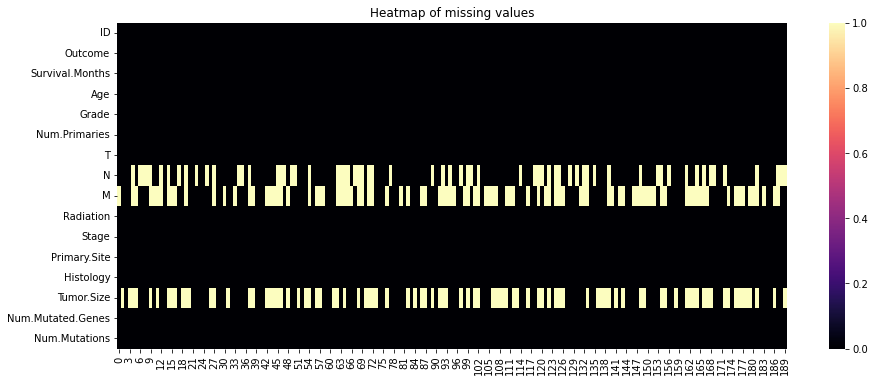

In [57]:
fig = plt.figure(figsize=(15,6))
sns.heatmap(clinical_df.isna().T, cmap='magma')
plt.title('Heatmap of missing values')

From the missing value matrix it can be seen that columns N,M and Tumor.Size have 65,96, and 92 missing entries.

* N is the number of metastasis to lymph nodes

* M is the numbers of distant metastases ('A distant metastasis refers to cancer that has spread from the original (primary) tumor to distant organs or distant lymph nodes. Also known as distant cancer.')

* Tumor.Size is the size of the tumor at the time of diagnosis

N,M,and Tumor.Size are of type float and as such are numerical continuous variables. The simplest way to deal with these missing entries is to fill them with either the median or the mode of the category depending on the shape of their distribution.


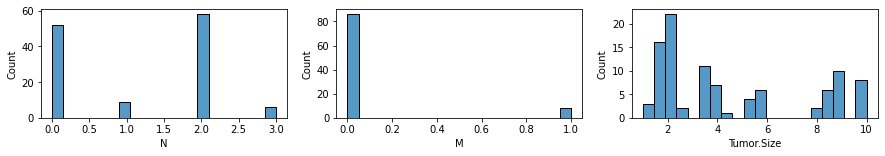

In [26]:
fig, ax = plt.subplots(1,3,figsize=(15,2))
ax = ax.ravel()
i = 0
nan_list = ['N','M','Tumor.Size']
for i  in range(3):
    sns.histplot(data = clinical_df, x = nan_list[i],ax=ax[i],bins = 20)
plt.show()

Tumor.Size at first glance appears to not be unimodal and may be slightly right skewed. I could try to stabilize the variance via a square root transform or a log transform. 

Hmmm, upon closer inspection N and M appear to have at discrete integer values. N only occurs at values of 0,1,2, or 3 while M only has values of 0 or 1. 

Let me check the number of unique values to ensure that's the case.

In [47]:
clinical_df.nunique()

ID                   190
Outcome                2
Survival.Months       28
Age                   20
Grade                  4
Num.Primaries          2
T                      9
N                      4
M                      2
Radiation              2
Stage                  9
Primary.Site           9
Histology              3
Tumor.Size            19
Num.Mutated.Genes      9
Num.Mutations          9
dtype: int64

Yep, N only has 4 unique values and M only has two unique values. As such, I will treat them as categorical variables instead which means that I will fill the empty entries of these two features with the mode. I will convert them to type 'int' as well.

In addition to this, since the Tumor.Size data is skewed, I will populate the missing entries with the median.

I also noticed that the Surival.Months column is being treated as a float, but it could be treated as an int for easier one hot encoding later. I'll make sure to convert it to that.

In [39]:
clinical_df2 = clinical_df.copy()
#Populate missing entries of N and M with the mode, and missing entries in Tumor.Size with the median
clinical_df2['N'].fillna(clinical_df2['N'].mode()[0], inplace=True)
clinical_df2['M'].fillna(clinical_df2['M'].mode()[0], inplace=True)
clinical_df2['Tumor.Size'].fillna(clinical_df2['Tumor.Size'].median(), inplace=True)
#Convert N and M to type int
clinical_df2 = clinical_df2.astype({"N": int, "M": int, "Survival.Months": int})
clinical_df2.isnull().sum()

ID                   0
Outcome              0
Survival.Months      0
Age                  0
Grade                0
Num.Primaries        0
T                    0
N                    0
M                    0
Radiation            0
Stage                0
Primary.Site         0
Histology            0
Tumor.Size           0
Num.Mutated.Genes    0
Num.Mutations        0
dtype: int64

No more NaNs! Let me ensure the types are parsed correctly so far.

In [40]:
clinical_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 190 non-null    int64  
 1   Outcome            190 non-null    object 
 2   Survival.Months    190 non-null    int32  
 3   Age                190 non-null    int64  
 4   Grade              190 non-null    int64  
 5   Num.Primaries      190 non-null    int64  
 6   T                  190 non-null    object 
 7   N                  190 non-null    int32  
 8   M                  190 non-null    int32  
 9   Radiation          190 non-null    int64  
 10  Stage              190 non-null    object 
 11  Primary.Site       190 non-null    object 
 12  Histology          190 non-null    object 
 13  Tumor.Size         190 non-null    float64
 14  Num.Mutated.Genes  190 non-null    int64  
 15  Num.Mutations      190 non-null    int64  
dtypes: float64(1), int32(3), i

Great! Now I'll get the basic descriptive statistics for this dataset

In [51]:
clinical_df2.describe()

,ID,Survival.Months,Age,Grade,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,95.500000,22.178947,70.173684,6.105263,0.226316,1.436842,0.042105,1.657895,4.061579,2.684211,3.084211
std,54.992424,12.428401,6.146909,2.995495,0.419551,0.927938,0.201360,2.360122,2.231247,1.460327,1.697575
min,1.000000,9.000000,56.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.250000,11.000000,67.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.600000,2.000000,2.000000
50%,95.500000,16.000000,71.000000,9.000000,0.000000,2.000000,0.000000,0.000000,3.600000,3.000000,3.000000
75%,142.750000,34.000000,74.000000,9.000000,0.000000,2.000000,0.000000,5.000000,3.600000,3.000000,4.000000
max,190.000000,71.000000,84.000000,9.000000,1.000000,3.000000,1.000000,5.000000,10.000000,8.000000,8.000000


## Part 4: Merging Dataframes
I've done initial clean-up and exploration of the data so far, before I do any subsequent visualization however, I want to briefly explore the genomics.csv file since it looks like I'll be able to merge these two dataframes together and include the Mutated Genes into the clinical_df based on the Patient ID. This will allow to create the number of features in my model quite a bit so it's a bit of a freebie in terms of feature engineering.

I will assume that the patients with the same ID contained within the genomics.csv data correspond to the patients with that ID on clinical.csv

In [7]:
genomics_df

,ID,Gene
0,1,AKT1
1,158,AKT1
2,88,ALK_Col1
3,132,ALK_Col1
4,18,ALK_Col2
...,...,...
505,167,TSC2
506,168,TSC2
507,180,TSC2
508,182,TSC2


Before anything else, I'll ensure that there are no missing values. 

In [97]:
genomics_df.isnull().sum()

ID      0
Gene    0
dtype: int64

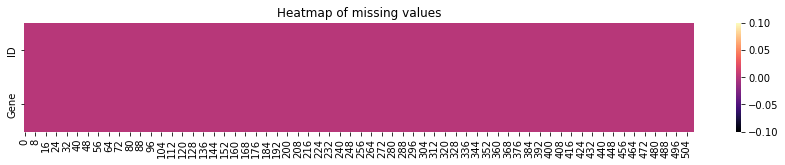

In [99]:
fig = plt.figure(figsize=(15,2))
sns.heatmap(genomics_df.isna().T, cmap='magma')
plt.title('Heatmap of missing values')
plt.show()

Great! NO missing data!

There are 510 entries on this dataframe. The clinical data has info for 190 patients. Are these 510 entries for unique patients?

In [67]:
genomics_df.nunique()

ID      184
Gene     50
dtype: int64

Hmm, there 184 unique patient IDs. Therefore, I should reshape my dataframe before continuing to better reflect this.

In [105]:
df2 = genomics_df.pivot(index='ID',columns='Gene',values='Gene')
df2

Gene,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,AKT1,NaN,NaN,NaN,NaN,NaN,NaN,CCND2,NaN,NaN,NaN,EGFR,NaN,NaN,NaN,NaN,NaN,FGFR3,NaN,NaN,NaN,NaN,KRAS_Col1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDGFRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STK11,NaN,NaN,NaN,TSC2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMO,NaN,NaN,TP53_Col1,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STK11,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CDKN2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PIK3CB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TP53_Col1,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KRAS_Col1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TP53_Col1,NaN,TSC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NF_Col3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KRAS_Col1,NaN,NaN,NaN,NaN,MSH2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TSC2
188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CDKN2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TP53_Col1,NaN,NaN


Ok, this is better. There is gene information for 184 patients. I don't want to drop any patients from my dataset because it is already fairly small, so instead I'll figure out which patients are missing genomic data and then simply enter NaN values for their gene info before I merge them. 

In [106]:
#Find missing integers within a given range in a list
gene_patients = df2.index.tolist() 

def find_missing(ls,ini,fin):
    """
    Args:
        ls: list to look missing numbers in
        ini: Beginning of range to look for integers in
        ini: End of range to look for integers in
        
    Returns:
        List of values missing from list
    """
    print('The missing patients are:')
    return [x for x in range(ini, fin + 1) if x not in ls]
  
ini = 1
fin = 190
print(find_missing(gene_patients,ini,fin))

The missing patients are:
[19, 30, 40, 89, 142, 166]


Nice! The missing patients are those with IDs of 19,30,40,89,142,166.

Now I have to decide how to handle them. I can either set the gene values to NaN (i.e., missing for these 6 patients after I merge the dataframes) or I can drop these 6 patients from the dataset and keep only the patients for whom I have a full set of data. 

If I were to fill in the gene values with missing or 0 or whichever constant filler value, then this would confound the model and may lead to more false positives/negatives. This is particularly troublesome in this scenario since a false positive would entail telling the patient that they will survive when they aren't going to, and a false negative would entail telling the patient that they will die when they are going to live.  

Given that, I think I've convinced myself that dropping these 6 patients for the time being is the right course of action. I can always come back and include them later and handle them in a more appropriate fashion if need be.

I'll fill the NaN values with 0 for this dataframe.

In [107]:
df2 = df2.fillna(0)
df2

Gene,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,AKT1,0,0,0,0,0,0,CCND2,0,0,0,EGFR,0,0,0,0,0,FGFR3,0,0,0,0,KRAS_Col1,0,0,0,0,0,0,0,0,0,0,0,0,PDGFRB,0,0,0,0,0,0,0,0,0,STK11,0,0,0,TSC2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SMO,0,0,TP53_Col1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,STK11,0,0,0,0
4,0,0,0,0,0,0,0,0,CDKN2A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MET,0,0,0,0,0,0,0,0,0,0,0,PIK3CB,0,0,0,0,0,0,0,0,0,TP53_Col1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,KRAS_Col1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TP53_Col1,0,TSC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NF_Col3,0,0,0,0,0,0,0,0,PTEN,0,0,0,0,0,0,0,0,0
187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,KRAS_Col1,0,0,0,0,MSH2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TSC2
188,0,0,0,0,0,0,0,0,CDKN2A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MET,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TP53_Col1,0,0


Nice! One more thing that I should is replace all nonzero values in each column with a 1. This is a bit of a roundabout way to get these gene features one hot encoded.

In [108]:
for col in df2.columns:
    df2.loc[df2[col] != 0, col] = 1
df2

Gene,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
188,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Perfect! Now I'm ready to merge these two dataframes. 

In [112]:
data_complete = clinical_df2.merge(df2, on="ID",how="inner")
data_complete

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
0,1,Alive,9,67,4,0,UNK,2,0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,2,Dead,19,73,2,0,UNK,2,0,5,IV,Right Upper Lobe,Adenocarcinoma,3.6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,3,Dead,13,72,3,0,2,2,0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Dead,15,69,9,1,1a,0,1,0,IA,Right Upper Lobe,Adenocarcinoma,3.6,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,5,Dead,10,76,9,0,UNK,2,0,0,IIIA,Left Hilar,Large-cell carcinoma,3.6,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,186,Dead,32,82,9,0,4,0,1,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
180,187,Dead,10,62,4,0,3,2,0,0,IVB,Left Hilar,Large-cell carcinoma,3.6,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
181,188,Dead,23,72,3,0,3,2,0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
182,189,Dead,32,67,4,1,1a,2,0,0,IV,Right Upper Lobe,Adenocarcinoma,10.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Awesome! The data I'll be working with now has 184 patients and I currently have 65 features to work with. Now I'll start visualizing these features and see if there's some more feature engineering I can do.

## Part 5: Visualizing Data Features and Data Engineering
I'll start by visualizing some of the variables that were present in the original clinical.csv data

In [119]:
data_complete.nunique()[:16]

ID                   184
Outcome                2
Survival.Months       27
Age                   20
Grade                  4
Num.Primaries          2
T                      9
N                      4
M                      2
Radiation              2
Stage                  9
Primary.Site           9
Histology              3
Tumor.Size            19
Num.Mutated.Genes      8
Num.Mutations          8
dtype: int64

In [130]:
def pie_plotter(features):
    """
    Args:
            ls: list of columns to make dataframes for
        Returns:
            Makes pie charts for features 
    """
    fig = plt.figure(figsize=(22,20))
    i = 0
    n_features = len(features)
    for feature in features:
        cardinality = data_complete[feature].nunique()
        colors  = pl.cm.coolwarm(np.linspace(0,1,cardinality))
        explode = [0.1] * cardinality

        labels = data_complete[feature].unique()   
        labels = [x for x in labels if str(x) != 'nan']

        ax1 = plt.subplot2grid((1,n_features),(0,i))
        plt.pie(data_complete[feature].value_counts(),autopct='%1.1f%%',textprops={'fontsize':14},colors = colors,shadow=True,labels=labels,explode = explode)
        plt.title(feature)
        i+=1
    plt.show()

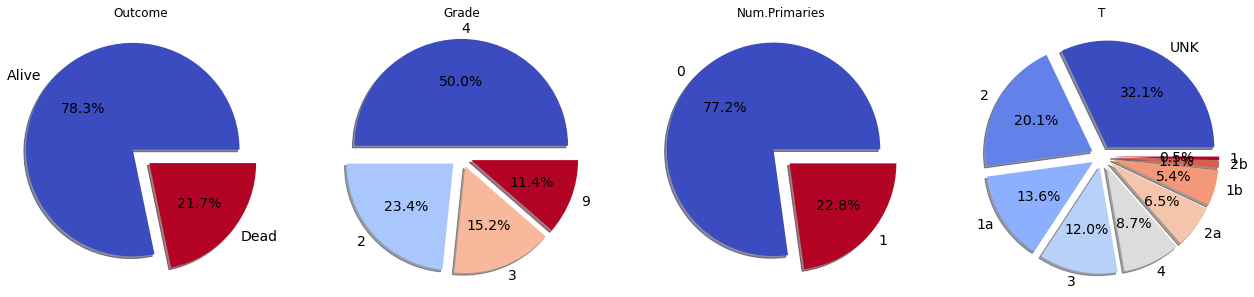

In [138]:
features = ['Outcome','Grade', 'Num.Primaries', 'T']
pie_plotter(features)

Observations:
* 78.3% of patients were alive a year after being diagnosed with NSCLC
* 50% of patients had a tumor grade of 4 (cells look as abnormal as they can [this is bad])
* 77.2% of patients have a value of 0 for Primary tumors
* 32.1% of patients have a tumor at an unknown stage. 20.1% of patients have a tumor of stage 2.

Takeaways:
* NSCLC diagnosis appears to have close to 80% survival rate a year after initial diagnosis
* Half of the patients had a Grade 4 tumor which is the most aggressive division a cancer can have
* Number of primary tumors has values of either 0 or 1. Does this mean that this value represent whether a primary tumor was present or not? In either case, nearly 80 percent of patients did not have a primary tumor at the time of diagnosis (Strong correlation with survival perhaps??)
* Maybe not having a tumor detected leads to increased survival


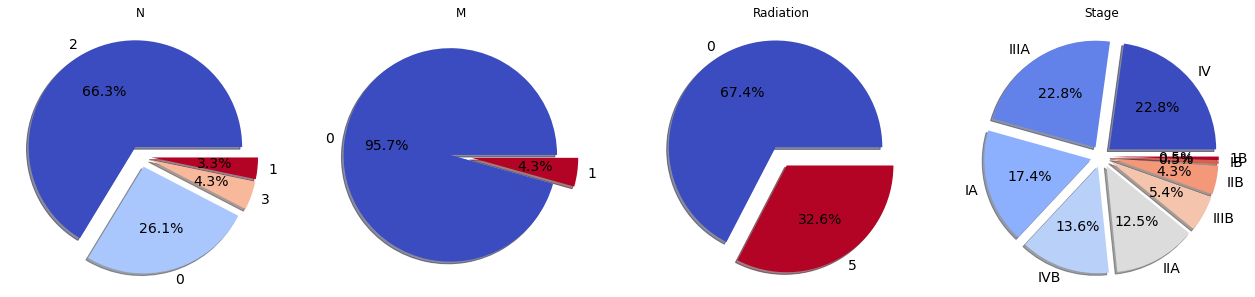

In [137]:
features = ['N','M', 'Radiation', 'Stage']
pie_plotter(features)

Observations:
* 66.3% of patients had 2 metastasis to lymph nodes
* 95.7% of patients had no distant metastases
* 67.4% of patients no radiation exposure
* 22.8% of patients had a tumor stage of IV or IIIA at the time of diagnosis

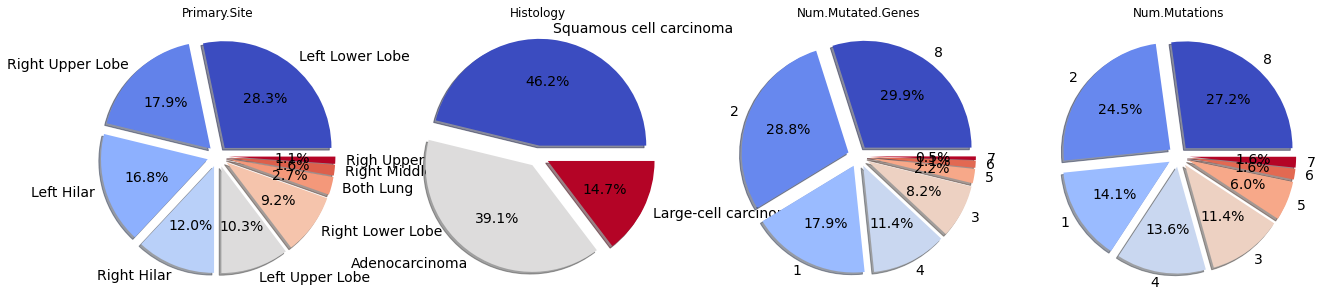

In [134]:
features = ['Primary.Site','Histology', 'Num.Mutated.Genes', 'Num.Mutations']
pie_plotter(features)

Observations:
* 28.3% of patients had their primary site as the Left Lower Lobe
* 46.2% of patients had Squamous cell carcinoma (2nd most common form of skin cancer)
* 29.9% of patients had 8 mutations in the tumor followed by 28.8% of patients had 2 mutations in the tumor 
* 27.2% of patients had 8 genes with mutation and 24.5% of patients had 2 genes with mutation

## Visualizing Relationships Between Features and Patient Survival
Ok, now I want to see what proportion for these various features are associated with patient survival

In [140]:
def make_countplot(features):
    fig, axs = plt.subplots(2,2,figsize=(15,8))
    ax = axs.ravel()
    i = 0
    for feature in features:
        sns.countplot(data=data_complete, x=feature, hue='Outcome', palette='plasma',ax= ax[i])
        ax[i].set_title(feature)
        i+=1
    fig.tight_layout() 
    plt.show()

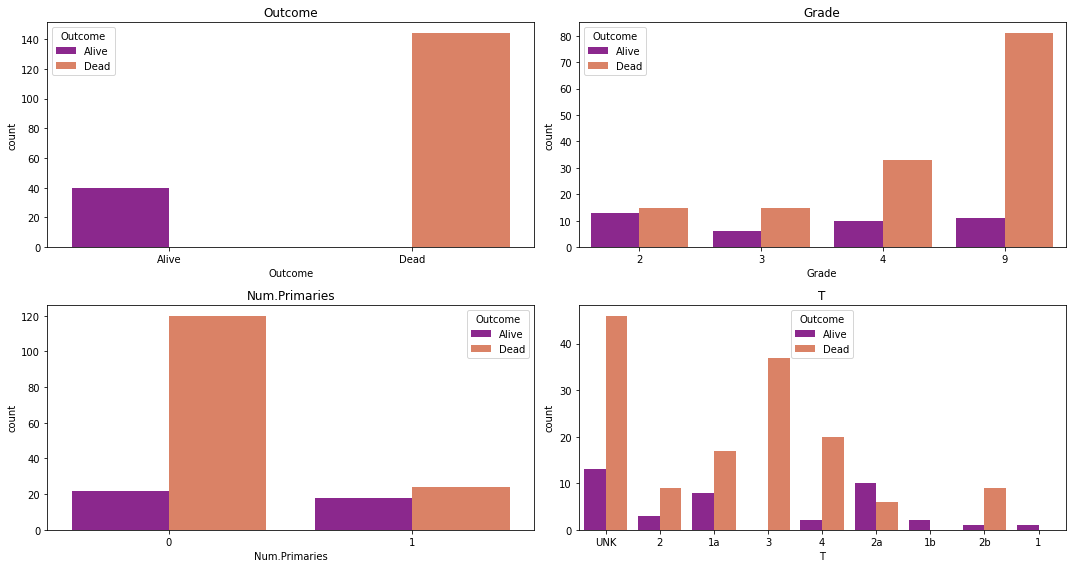

In [141]:
features = ['Outcome','Grade', 'Num.Primaries', 'T']
make_countplot(features)

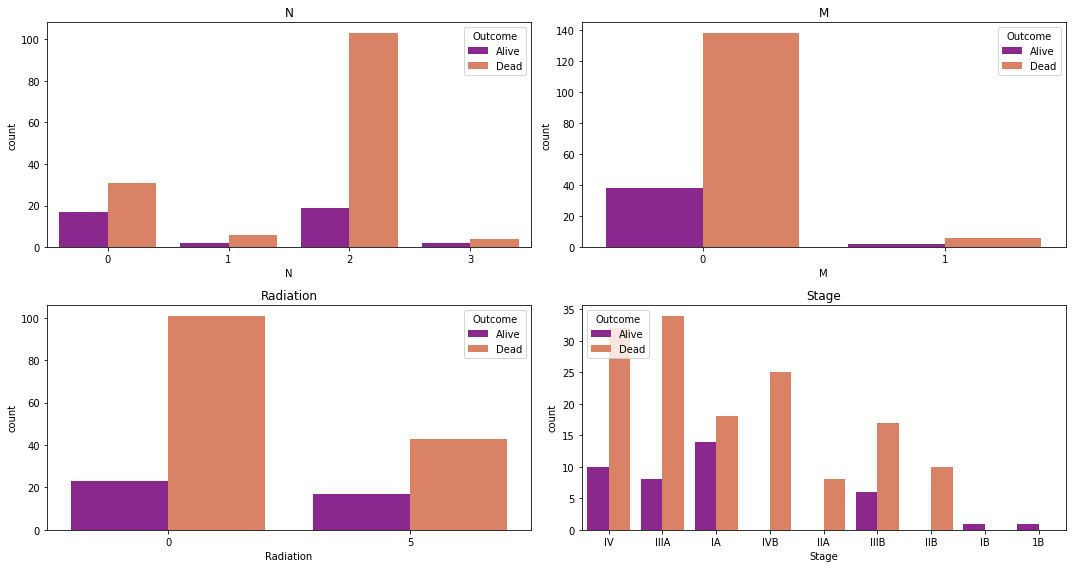

In [142]:
features = ['N','M', 'Radiation', 'Stage']
make_countplot(features)

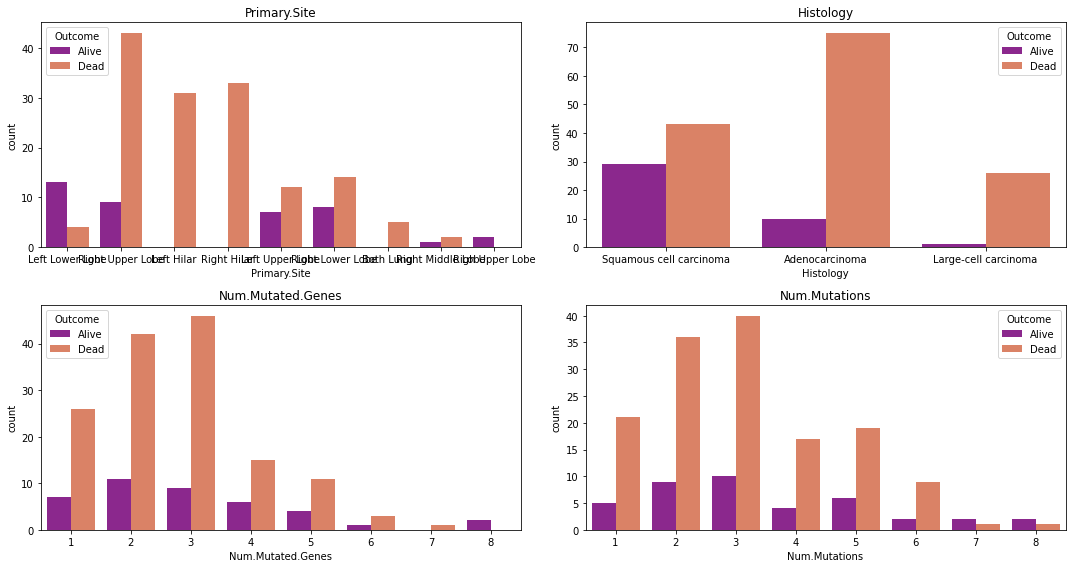

In [143]:
features = ['Primary.Site','Histology', 'Num.Mutated.Genes', 'Num.Mutations']
make_countplot(features)